# **Perhitungan Manual Ekstraksi Kata Menggunakan Textrank**

Rumus TextRank:

$$ W_i = (1 - d) + d \cdot \sum_{j \in In(i)} \frac{w_{ij}}{\sum_{k \in Out(j)} w_{jk}} \cdot W_j $$

Penjelasan unsur-unsur dalam rumus tersebut:

- $(W_i)$: Skor TextRank untuk kata $(i)$.
- $(d)$: Faktor redaman (damping factor), seringkali bernilai sekitar 0.85.
- $(In(i))$: Himpunan kata-kata yang memiliki hubungan (edge) masuk ke kata $(i)$.
- $(Out(j))$: Himpunan kata-kata yang memiliki hubungan keluar dari kata $(j)$.
- $(w_{ij})$: Bobot hubungan antara kata $(i)$ dan $(j)$.

Rumus secara rinci:

$$ W_i = (1 - d) + d \cdot \sum_{j \in In(i)} \frac{w_{ij}}{\sum_{k \in Out(j)} w_{jk}} \cdot W_j $$

Penjelasan langkah-langkah rumus:

1. $(1 - d)$: Bagian dari rumus yang menyatakan kontribusi dampak faktor redaman.
2. $(\sum_{j \in In(i)})$: Penjumlahan atas kata-kata yang memiliki hubungan masuk ke kata $(i)$.
3. $(\frac{w_{ij}}{\sum_{k \in Out(j)} w_{jk}})$: Bagian yang menghitung kontribusi dari setiap kata yang memiliki hubungan keluar dari kata $(j)$. Fungsi ini memperhitungkan bobot relatif dari setiap hubungan keluar dari kata $(j)$.
4. $(W_j)$: Skor TextRank dari kata $(j)$. Skor ini dihitung pada iterasi sebelumnya dan digunakan untuk menghitung skor baru untuk kata $(i)$.

Dengan mengulangi rumus ini melalui beberapa iterasi, nilai skor TextRank untuk setiap kata akan konvergen ke nilai yang mencerminkan tingkat kepentingan kata-kata dalam teks. Pada akhirnya, kata-kata dengan skor TextRank tertinggi dianggap sebagai kata kunci atau kata-kata yang paling penting dalam teks tersebut.

## Import Library

In [1]:
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
import nltk
import re

nltk.download('stopwords')
nltk.download('punkt')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Kode tersebut adalah pengaturan awal untuk analisis teks menggunakan Python. Pustaka yang diimpor antara lain NLTK untuk tokenisasi dan stopwords, Scikit-learn untuk ekstraksi fitur teks, NetworkX untuk analisis jaringan, Seaborn dan Matplotlib untuk visualisasi, serta beberapa pustaka lainnya. Warnings diatur untuk diabaikan agar tidak mengganggu keluaran. Download dilakukan untuk model stopword dan tokenizer dari NLTK.

## Stopwords Removal

Fungsi bernama `stopwords` yang mengambil teks sebagai input dan mengembalikan teks yang telah dihilangkan kata-kata stopwords dalam bahasa Indonesia. Fungsi ini menggunakan daftar kata-kata stopwords yang sudah diambil dari NLTK. Jika ada hal lain yang ingin ditanyakan atau dijelaskan, silakan beri tahu!

In [2]:
corpus = stopwords.words('indonesian')
def stopwords(text):
  return ' '.join(word for word in text.split() if word not in corpus)

## Fungsi Plot Graph

Fungsi `plot_graph` digunakan untuk menggambar graf yang diberikan dengan menggunakan pustaka NetworkX dan Matplotlib. Berikut adalah penjelasan singkat setiap bagian kode:

1. `def plot_graph(G, figsize=(35, 30), node_size=700, node_color='skyblue'):`
   - Mendefinisikan fungsi `plot_graph` yang mengambil graf `G` sebagai parameter dan memiliki beberapa parameter opsional seperti `figsize` (ukuran gambar), `node_size` (ukuran simpul), dan `node_color` (warna simpul).

2. `pos = nx.spring_layout(G)  # Menentukan posisi simpul`
   - Menentukan posisi simpul menggunakan layout spring (metode penataan simpul). Layout spring digunakan untuk merencanakan simpul secara visual dengan mempertimbangkan gaya pegas antara simpul-simpul.

3. `labels = nx.get_edge_attributes(G, 'weight')`
   - Mendapatkan atribut berat (weight) dari setiap sisi (edge) di graf. Atribut ini kemungkinan digunakan untuk memberikan bobot pada sisi-sisi graf.

4. `plt.figure(figsize=figsize)`
   - Menentukan ukuran canvas untuk gambar graf menggunakan Matplotlib.

5. `nx.draw(G, pos, with_labels=True, node_size=node_size, node_color=node_color)`
   - Menggambar graf dengan menggunakan NetworkX. `pos` adalah posisi simpul yang telah ditentukan sebelumnya, `with_labels=True` mengaktifkan label simpul, `node_size` adalah ukuran simpul, dan `node_color` adalah warna simpul.

6. `nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='red')`
   - Menambahkan label pada setiap sisi graf dengan menggunakan atribut berat (`labels`). Warna teks label diatur menjadi merah (`font_color='red'`).

7. `plt.show()`
   - Menampilkan gambar graf.

In [3]:
def plot_graph(G, figsize=(35, 30), node_size=700, node_color='skyblue'):
  # Menggambar graf dengan canvas yang diperbesar
  pos = nx.spring_layout(G)  # Menentukan posisi simpul
  labels = nx.get_edge_attributes(G, 'weight')

  # Menentukan ukuran canvas
  plt.figure(figsize=figsize)

  # Menggambar graf dengan ukuran canvas yang diperbesar
  nx.draw(G, pos, with_labels=True, node_size=node_size, node_color=node_color)
  nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='red')
  plt.show()

## Fungsi Membuat Graph dengan Co-occurence Matriks

Fungsi `graph_co_occurrence` pada kode tersebut digunakan untuk membuat graf berdasarkan matriks co-occurrence dari teks yang diberikan. Berikut adalah penjelasan singkatnya:

- `vectorizer = CountVectorizer()`: Membuat objek CountVectorizer untuk menghitung frekuensi kemunculan kata-kata.
- `tfidf_matrics = vectorizer.fit_transform(x)`: Mengubah teks menjadi matriks TF-IDF (Term Frequency-Inverse Document Frequency).
- `co_occurrence_matrix = tfidf_matrics.T.dot(tfidf_matrics).toarray()`: Menghitung matriks co-occurrence dari matriks TF-IDF.
- `df_co_occurrence = pd.DataFrame(co_occurrence_matrix, columns=vectorizer.get_feature_names_out())`: Membuat DataFrame dari matriks co-occurrence.
- `if show_matrics: display(df_co_occurrence)`: Jika `show_matrics` bernilai `True`, maka tampilkan matriks co-occurrence.
- `G = nx.DiGraph()`: Membuat objek graf yang merupakan directed graph (graf berarah) menggunakan NetworkX.
- Looping untuk menambahkan edge ke graf berdasarkan matriks co-occurrence dengan bobot di atas ambang batas (`threshold`).
- Mengembalikan objek graf (`G`).

Fungsi ini berguna untuk membentuk graf berdasarkan hubungan co-occurrence antar-kata dalam teks, dengan memanfaatkan matriks co-occurrence.

In [4]:
def graph_co_occurrence(x, show_matrics=False):
  vectorizer = CountVectorizer()
  tfidf_matrics = vectorizer.fit_transform(x)
  co_occurrence_matrix = tfidf_matrics.T.dot(tfidf_matrics).toarray()
  df_co_occurence = pd.DataFrame(co_occurrence_matrix, columns=vectorizer.get_feature_names_out())
  df_co_occurence.insert(0, 'Word', vectorizer.get_feature_names_out())

  if show_matrics:
    print("Tabel Co-occurence Matrics: ")
    display(df_co_occurence)
    print()

  # Membuat graf berbobot menggunakan NetworkX
  G = nx.DiGraph()
  num_words = co_occurrence_matrix.shape[0]

  # Menambahkan edge ke graf berdasarkan matriks co-occurrence
  for i in range(num_words):
    for j in range(i + 1, num_words):
      weight = co_occurrence_matrix[i, j]
      if weight > 0:
        G.add_edge(vectorizer.get_feature_names_out()[i], vectorizer.get_feature_names_out()[j], weight=weight)
  return G

## Fungsi Text Rank Manual

Fungsi `text_rank` ini mengimplementasikan algoritma TextRank untuk menghitung skor peringkat (ranks) pada setiap node dalam suatu graf. Berikut adalah penjelasan langkah-langkahnya:

1. `initial_value = 1 / graph.number_of_nodes()`: Menentukan nilai awal TextRank untuk setiap node sebagai kebalikan dari jumlah total node dalam graf.

2. `ranks = {node: initial_value for node in graph.nodes()}`: Menginisialisasi dictionary `ranks` yang menyimpan skor peringkat awal untuk setiap node dalam graf.

3. `for i in range(max_iter):`: Memulai iterasi sebanyak `max_iter`.

4. `new_ranks = {}`: Membuat dictionary baru untuk menyimpan skor peringkat yang baru dihitung pada setiap iterasi.

5. Iterasi pada setiap node dalam graf:
   - `for node in graph.nodes():`
     - `rank_sum = 0`: Menyimpan jumlah dari kontribusi peringkat dari tetangga setiap node.
     - `operasi = ''`: Menyimpan informasi operasi matematika yang dijalankan pada setiap node.
     - `out_sums_info = {}`: Menyimpan informasi out_sum (jumlah bobot sisi keluar) dan bobot untuk setiap tetangga node.
     - `win = graph.in_degree(node, weight="weight")`: Menghitung jumlah bobot sisi masuk ke node (in_degree).

   - Iterasi pada setiap tetangga node:
     - `for neighbor in graph.predecessors(node):`
       - `edge_weight = graph[neighbor][node]["weight"]`: Mengambil bobot sisi antara node dan tetangganya.
       - `out_sum = sum(graph[neighbor][out_neighbor]["weight"] for out_neighbor in graph.successors(neighbor))`: Menghitung out_sum, yaitu jumlah bobot sisi keluar dari tetangga node.
       - `rank_sum += (edge_weight / out_sum) * ranks[neighbor]`: Menambahkan kontribusi peringkat dari tetangga node.
       - `operasi += f"({edge_weight}/{out_sum}) * {ranks[neighbor]} + "`: Membuat string operasi yang dijalankan pada setiap tetangga node.
       - `out_sums_info[neighbor] = {out_neighbor: graph[neighbor][out_neighbor]["weight"] for out_neighbor in graph.successors(neighbor)}`: Menambahkan informasi out_sum untuk setiap tetangga node.

     - `operasi = operasi[:-3] if operasi else '0'`: Jika operasi kosong, atur nilai operasi menjadi 0.

     - `new_rank = (1 - damping_factor) + damping_factor * rank_sum`: Menghitung skor peringkat baru untuk node berdasarkan kontribusi dari tetangga-tetangganya.
     - `new_ranks[node] = new_rank`: Menyimpan skor peringkat baru untuk node dalam dictionary `new_ranks`.

     - Menampilkan informasi out_sum dan win untuk setiap node dan tetangganya.
     - Menampilkan operasi matematika yang dijalankan pada setiap node.
     - Menampilkan skor peringkat baru untuk setiap node.

6. `convergence = all(abs(new_ranks[node] - ranks[node]) < tol for node in graph.nodes())`: Mengecek apakah terjadi konvergensi dengan memeriksa apakah peringkat node pada iterasi sebelumnya dan iterasi sekarang sudah konvergen dengan toleransi `tol`.

7. `ranks = new_ranks`: Memperbarui dictionary `ranks` dengan skor peringkat yang baru dihitung.

8. Menampilkan skor peringkat yang baru dihitung.

9. `if convergence: ...`: Jika terjadi konvergensi, menghentikan iterasi dan menampilkan pesan konvergensi tercapai.

10. Mengembalikan dictionary `ranks` yang berisi skor peringkat terakhir untuk setiap node dalam graf.

In [5]:
def text_rank(graph, damping_factor=0.85, max_iter=100, tol=1e-4):
  # Inisialisasi nilai TextRank untuk setiap node
  initial_value = 1 / graph.number_of_nodes()
  ranks = {node: initial_value for node in graph.nodes()}

  print(f"Inisialisasi Score Awal : {ranks}")
  print(f"Edges : {graph.edges()}")
  print()

  for i in range(max_iter):
    new_ranks = {}
    print(f"========== Iterasi Ke - {i} ==========")

    for node in graph.nodes():
      rank_sum = 0
      operasi = ''

      # Menampilkan informasi out_sum dan win untuk setiap node dan neighbor
      out_sums_info = {}
      win = graph.in_degree(node, weight="weight")

      for neighbor in graph.predecessors(node):
        edge_weight = graph[neighbor][node]["weight"]
        out_sum = sum(graph[neighbor][out_neighbor]["weight"] for out_neighbor in graph.successors(neighbor))
        rank_sum += (edge_weight / out_sum) * ranks[neighbor]
        operasi += f"({edge_weight}/{out_sum}) * {ranks[neighbor]} + "

        # Menambah informasi out_sum untuk setiap neighbor
        out_sums_info[neighbor] = {out_neighbor: graph[neighbor][out_neighbor]["weight"] for out_neighbor in graph.successors(neighbor)}

      # Jika operasi kosong, atur nilai operasi menjadi 0
      operasi = operasi[:-3] if operasi else '0'

      new_rank = (1 - damping_factor) + damping_factor * rank_sum
      new_ranks[node] = new_rank

      # Menampilkan informasi out_sum dan win pada setiap iterasi
      print(f"Win({node}): {win}")
      print(f"Out_sums_info({node}): {out_sums_info}")
      print(f"W({node}) = (1 - {damping_factor}) + {damping_factor} * ({operasi}) = {new_rank}")
      print()

    # Periksa konvergensi
    convergence = all(abs(new_ranks[node] - ranks[node]) < tol for node in graph.nodes())
    ranks = new_ranks
    print(f"New Score : {new_ranks}")
    print()

    if convergence:
      print(f"Konvergensi tercapai pada iterasi ke-{i}")
      break

  return ranks

## Fungsi Ekstrak Kata Kunci Teratas

Fungsi `extract_top_words` ini mengambil teks (`x`) dan melakukan beberapa langkah pemrosesan untuk mengekstrak kata kunci berdasarkan skor TextRank. Berikut adalah penjelasan singkat langkah-langkahnya:

1. `full_text = ' '.join(word for word in x)`: Menggabungkan kata-kata dalam teks menjadi satu string `full_text`.

2. `x = [stopwords(full_text)]`: Menghilangkan kata-kata stopwords dari `full_text` menggunakan fungsi `stopwords`.

3. `G = graph_co_occurrence(x, show_matrics)`: Membuat graf co-occurrence menggunakan fungsi `graph_co_occurrence` dengan teks yang sudah dihilangkan stopwords (`x`). Graf ini akan digunakan untuk menghitung skor TextRank.

4. `scores = text_rank(G)`: Menghitung skor TextRank menggunakan fungsi `text_rank` pada graf co-occurrence yang dibuat.

5. `ranked_words_dict = {}`: Membuat dictionary untuk menyimpan skor tertinggi setiap kata.

6. Iterasi pada setiap kata dalam teks yang sudah dihilangkan stopwords:
   - `for word in ' '.join(x).split():`
     - `current_score = scores.get(word, 0)`: Mendapatkan skor TextRank untuk kata saat ini.
     - Memperbarui dictionary `ranked_words_dict` dengan skor tertinggi untuk setiap kata.

7. `ranked_words = sorted(((score, word) for word, score in ranked_words_dict.items()), key=lambda x: (x[0], x[1]), reverse=True)`: Mengurutkan kata-kata berdasarkan skor tertinggi.

8. `selected_words = [word for _, word in ranked_words[:w]] if w is not None else None`: Memilih sejumlah w kata tertinggi.

9. `keywords = ', '.join(selected_words) if selected_words else ''`: Menggabungkan kata-kata terpilih menjadi satu string terpisah dengan koma.

10. Jika `show_scores` diatur sebagai True, mencetak teks dokumen, kata kunci, dan skor TextRank untuk setiap kata.

11. Mengembalikan tuple berisi graf co-occurrence (`G`) dan kata kunci terpilih (`selected_words`).

In [6]:
def extract_top_words(x, w=3, show_matrics=False, show_scores=False, index=None):
    full_text = ' '.join(word for word in x)

    # Stopwords removal
    x = [stopwords(full_text)]

    G = graph_co_occurrence(x, show_matrics)

    # Menghitung nilai dari PageRank (TextRank)
    scores = text_rank(G)

    # Dictionary untuk menyimpan skor tertinggi setiap kata
    ranked_words_dict = {}

    for word in ' '.join(x).split():
        current_score = scores.get(word, 0)
        if word not in ranked_words_dict or current_score > ranked_words_dict[word]:
            ranked_words_dict[word] = current_score

    # Mengurutkan kata-kata berdasarkan skor tertinggi
    ranked_words = sorted(((score, word) for word, score in ranked_words_dict.items()), key=lambda x: (x[0], x[1]), reverse=True)

    # Memilih sejumlah w kata tertinggi
    selected_words = [word for _, word in ranked_words[:w]] if w is not None else None

    # Menggabungkan kata-kata menjadi satu string terpisah dengan koma
    keywords = ', '.join(selected_words) if selected_words else ''

    if show_scores:
      print(f'Dokumen ke {index} : {full_text}')
      print(f'{w} Kata Kunci : {keywords}')
      print("TextRank Scores:")
      for score, word in ranked_words:
          print(f"Skor: {score}, Kata: {word}")

    return (G, selected_words)

## Uji Coba dengan data

Melakukan uji coba dengan kalimat dan menampilkan tabel co-occurence serta proses perhitungan nya

In [7]:
text = ['Ibu Pergi Ke Pasar']
G, keywords = extract_top_words(text, w=2, show_matrics=True)

Tabel Co-occurence Matrics: 


,Word,ibu,ke,pasar,pergi
0,ibu,1,1,1,1
1,ke,1,1,1,1
2,pasar,1,1,1,1
3,pergi,1,1,1,1



Inisialisasi Score Awal : {'ibu': 0.25, 'ke': 0.25, 'pasar': 0.25, 'pergi': 0.25}
Edges : [('ibu', 'ke'), ('ibu', 'pasar'), ('ibu', 'pergi'), ('ke', 'pasar'), ('ke', 'pergi'), ('pasar', 'pergi')]

========== Iterasi Ke - 0 ==========
Win(ibu): 0
Out_sums_info(ibu): {}
W(ibu) = (1 - 0.85) + 0.85 * (0) = 0.15000000000000002

Win(ke): 1
Out_sums_info(ke): {'ibu': {'ke': 1, 'pasar': 1, 'pergi': 1}}
W(ke) = (1 - 0.85) + 0.85 * ((1/3) * 0.25) = 0.22083333333333335

Win(pasar): 2
Out_sums_info(pasar): {'ibu': {'ke': 1, 'pasar': 1, 'pergi': 1}, 'ke': {'pasar': 1, 'pergi': 1}}
W(pasar) = (1 - 0.85) + 0.85 * ((1/3) * 0.25 + (1/2) * 0.25) = 0.32708333333333334

Win(pergi): 3
Out_sums_info(pergi): {'ibu': {'ke': 1, 'pasar': 1, 'pergi': 1}, 'ke': {'pasar': 1, 'pergi': 1}, 'pasar': {'pergi': 1}}
W(pergi) = (1 - 0.85) + 0.85 * ((1/3) * 0.25 + (1/2) * 0.25 + (1/1) * 0.25) = 0.5395833333333333

New Score : {'ibu': 0.15000000000000002, 'ke': 0.22083333333333335, 'pasar': 0.32708333333333334, 'pergi': 0

## Graph yang di hasilkan

Menampilkan hasil graphnya

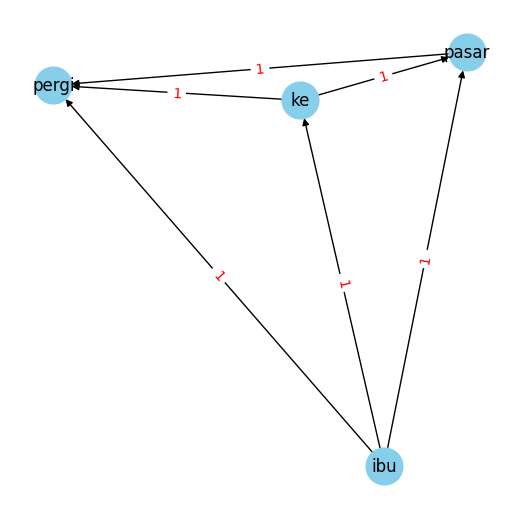

In [8]:
plot_graph(G, figsize=(5, 5), node_size=700,)

## Keywoards Yang di hasilkan

Menghasilkan keywords

In [9]:
keywords

['Pergi', 'Pasar']